In [21]:
import re
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


%matplotlib inline
plt.style.use('bmh')
warnings.filterwarnings('ignore')

# I. Data Acquisition

In [7]:
train_df = pd.read_csv('data/Data_Train.csv')
test_df = pd.read_csv('data/Data_Test.csv')
train_df.head()

,Unique_ID,Name,Genre,Country,Song_Name,Timestamp,Views,Comments,Likes,Popularity,Followers
0,413890,Hardstyle,danceedm,AU,N-Vitral presents BOMBSQUAD - Poison Spitter (...,2018-03-30 15:24:45.000000,14017,4,499,97,119563
1,249453,Dj Aladdin,danceedm,AU,Dj Aladdin - Old School Hip Hop Quick Mix,2016-06-20 05:58:52.000000,1918,17,49,17,2141
2,681116,Maxximize On Air,danceedm,AU,Maxximize On Air - Mixed by Blasterjaxx - Epis...,2015-05-08 17:45:59.000000,9668,11,312,91,22248
3,387253,GR6 EXPLODE,rbsoul,AU,MC Yago - Tenho Compromisso (DJ R7),2017-06-08 23:50:03.000000,113036,2,"2,400",76,393655
4,1428029,Tritonal,danceedm,AU,Escape (feat. Steph Jones),2016-09-17 20:50:19.000000,110024,81,"3,031",699,201030


## 1.0 Examine the data quality
There is no missing data. Note that "Likes" and "Popularity" are in string format.

In [3]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78458 entries, 0 to 78457
Data columns (total 11 columns):
Unique_ID     78458 non-null int64
Name          78458 non-null object
Genre         78458 non-null object
Country       78458 non-null object
Song_Name     78457 non-null object
Timestamp     78458 non-null object
Views         78458 non-null int64
Comments      78458 non-null int64
Likes         78458 non-null object
Popularity    78458 non-null object
Followers     78458 non-null int64
dtypes: int64(4), object(7)
memory usage: 6.6+ MB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19615 entries, 0 to 19614
Data columns (total 10 columns):
Unique_ID     19615 non-null int64
Name          19615 non-null object
Genre         19615 non-null object
Country       19615 non-null object
Song_Name     19615 non-null object
Timestamp     19615 non-null object
Comments      19615 non-null int64
Likes         19615 non-null object
Popularity   

## 1.1 Convert "Likes" and "Popularity" to numeric data type

In [13]:
def conv_numeric_feature(feature):
    feature = feature.replace(',', '')
    vals = [int(val) for val in re.findall('\d+', feature)]
    if len(vals) == 1:
        return vals[0] * 1000 if 'K' in feature else vals[0] 
    elif len(vals) == 2:
        if '.' in feature:
            value = vals[0] + 0.1 * vals[1]
            if 'K' in feature:
                value = value * 1000
            return value
        return None
    else:
        return None

In [14]:
train_df['Likes'] = train_df['Likes'].apply(lambda likes: conv_numeric_feature(likes))
train_df['Popularity'] = train_df['Popularity'].apply(lambda popularity: conv_numeric_feature(popularity))
test_df['Likes'] = test_df['Likes'].apply(lambda likes: conv_numeric_feature(likes))
test_df['Popularity'] = test_df['Popularity'].apply(lambda popularity: conv_numeric_feature(popularity))

In [15]:
train_info_df = pd.DataFrame(train_df.dtypes)
train_info_df['MissingVal'] = train_df.isnull().sum()
train_info_df['NUnique'] = train_df.nunique()
train_info_df['Count'] = train_df.count()
train_info_df = train_info_df.rename(columns = {0: 'DataType'})
train_info_df

,DataType,MissingVal,NUnique,Count
Unique_ID,int64,0,78458,78458
Name,object,0,1209,78458
Genre,object,0,21,78458
Country,object,0,1,78458
Song_Name,object,1,78457,78457
Timestamp,object,0,68187,78458
Views,int64,0,53964,78458
Comments,int64,0,2152,78458
Likes,float64,0,9211,78458
Popularity,float64,0,5719,78458


# II. Exploratory Analysis
The following features are screened for analysis and to be used for prediction.
<ul>
    <li>Qualitative feature: Genre</li>
    <li>Quantitative features: Views, Comments, Likes, Popularity, Followers, Timestamp</li>
</ul>

In [16]:
quan_train_df = train_df.select_dtypes(include=[np.number])
quan_train_df.drop(['Unique_ID'], axis=1, inplace=True)
print(quan_train_df.shape)
print(quan_train_df.columns)

(78458, 5)
Index(['Views', 'Comments', 'Likes', 'Popularity', 'Followers'], dtype='object')


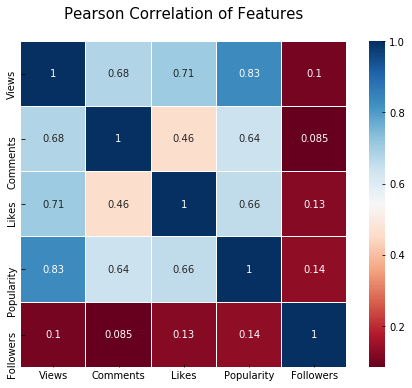

In [19]:
colormap = plt.cm.RdBu
plt.figure(figsize=(8, 6))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(quan_train_df.astype(float).corr(), linewidths=0.1, vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True)

Elapsed time: 5.7932 seconds


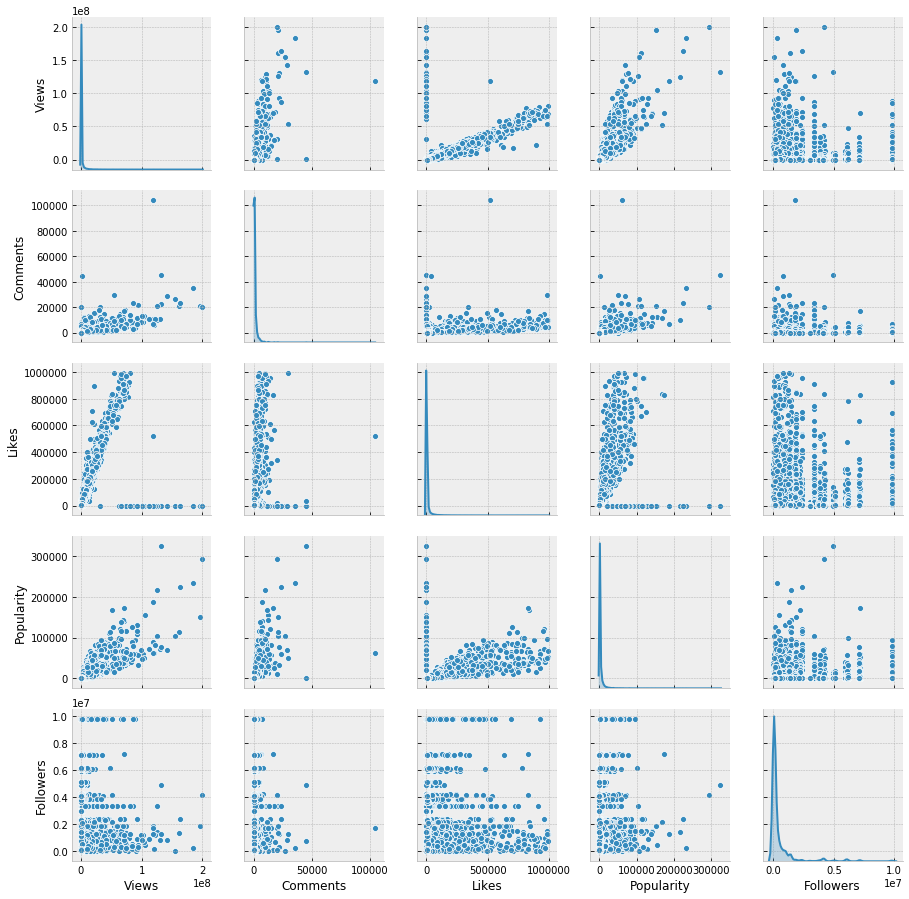

In [22]:
start_time = time.time()
sns.pairplot(quan_train_df, diag_kind="kde")
print("Elapsed time: %s seconds" % round(time.time() - start_time, 4))

## 2.0 Univariate Analysis

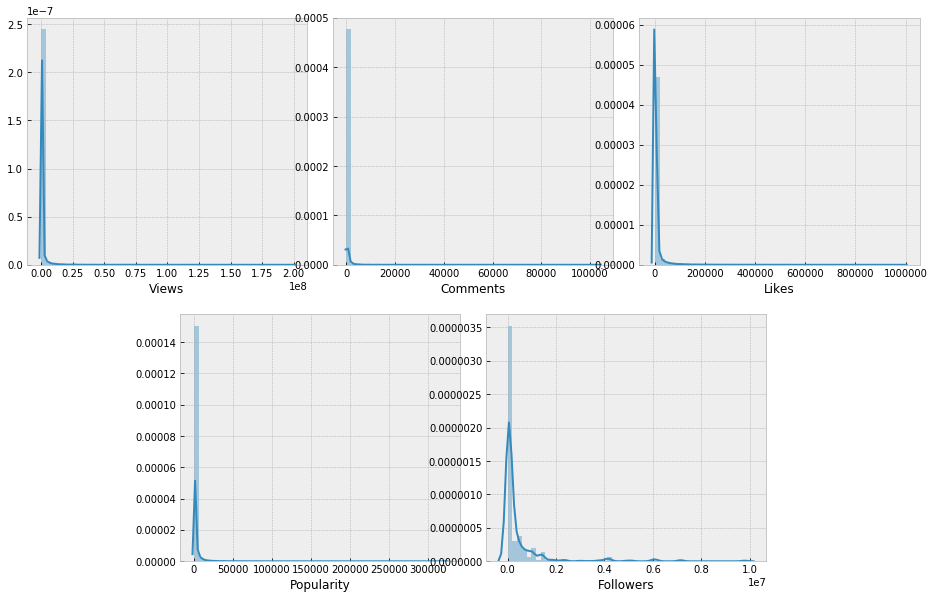

In [27]:
fig = plt.figure(figsize=(16, 10))
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)

sns.distplot(train_df['Views'], kde=True, ax=ax1)
sns.distplot(train_df['Comments'], kde=True, ax=ax2)
sns.distplot(train_df['Likes'], kde=True, ax=ax3)
sns.distplot(train_df['Popularity'], kde=True, ax=ax4)
sns.distplot(train_df['Followers'], kde=True, ax=ax5)